In [5]:
# Import numpy and matplotlib
from collections import namedtuple
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import netCDF4 as nc
import os


# Example plots

This notebook contains example code, showing how to plot the results of the two different implementations. Note that you must first run the simulations before you can plot the results. By default, both the simulation scripts and this notebook expects the results to be found in ```../results/```, but that can be changed. Note also that the numerical parameters are contained in the filenames of the results files, so the parameters in the example below must be set to match the simulations you ran.

# Diffusivity profile

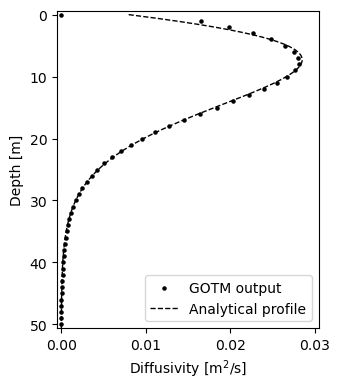

In [2]:
zc = np.linspace(0, 100, 1000)

fig = plt.figure(figsize = (3.5, 4))

with nc.Dataset('../gotm/entrainment.nc') as d:
    # Strip away superfluous size-1 dimensions from GOTM output
    avh = np.array(d.variables['avh'][:,:,0,0])
    z = np.array(np.abs(d.variables['z'][0,:,0,0]))
    z = z - z[-1]
    
    outputtime = 72*3600
    it = np.argmin(np.abs(d.variables['time'][:] - outputtime))
    plt.scatter(avh[it,1::2], z[1::2], marker = '.', s = 20, lw  = 1, c = 'k', label = 'GOTM output')

    a, b, c, z0 = [0.00636, 0.088, 1.54, 1.3]
    K_B = lambda z: a*(z+z0)*np.exp(-(b*(z+z0))**c)

    plt.plot(K_B(zc), zc, '--', c = 'k', lw = 1, alpha = 1, label = 'Analytical profile')
    
    plt.ylim(50.6, -0.6)
    plt.xlim(-0.0005,0.0305)
    plt.ylabel('Depth [m]')
    plt.xlabel('Diffusivity [m$^2$/s]')
    plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.savefig('diffusivity_profile.pdf')

# Plot concentration comparison

Run with larger number of particles (```--Np``` argument on command line) for smoother looking plots, and reduced timestep for better agreement between implementations.

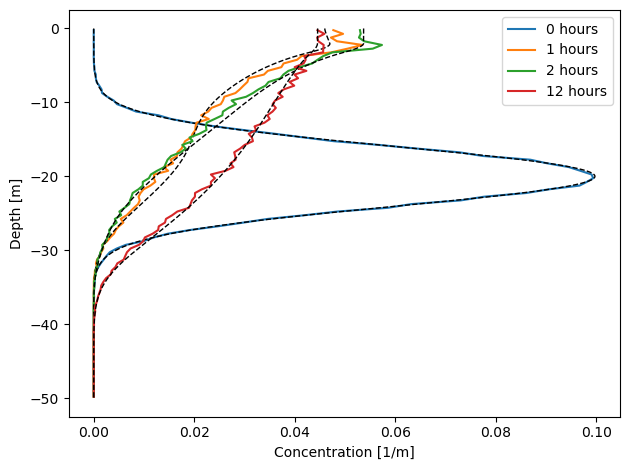

In [9]:
case = 3
profile = 'B'
# Update this to point to where you stored the simulation results
datafolder = '../results'

# Eulerian parameters to plot for
NJ = 1000  # Number of cells
NK = 8     # Number of classes
dt_E = 300 # Timestep
dt_save_E = 3600 # Interval for storing results

# Lagrangian parameters to plot for
Np = 100000 # Number of particles
dt_L = 30  # Timestep
dt_save_L = 3600 # Interval for storing results
run_id = 0 # Ensemble member

# Number of bins to use in particle histogram
Nbins = 100
# Max depth (constant for all cases)
Zmax = 50

# Load Lagrangian results
# The array Z has shape (Nt, Np)
# where Nt is number of output times and Np is number of particles
Z = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt_L}_save_dt={dt_save_L}_Z_{run_id:04}.npy'))
# Histogram bins and midpoints
bins, delta = np.linspace(0, Zmax, Nbins+1, retstep = True)
mids = bins[:-1] + delta/2

# Load Eulerian results
# The array C has shape (Nt, Nk, Nz)
# where Nt is number of output times, Nk is number of classes and Nz is number of cells
C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={dt_E}_save_dt={dt_save_E}.npy'))
# Cell faces and cell centers
zf, dz = np.linspace(0, Zmax, C.shape[-1]+1, retstep=True)
zc = zf[:-1] + dz/2

# Plot a few different timesteps
for hours in [0, 1, 2, 12]:
    # Find closest available stored timestep for Lagrangian results
    it = int(hours*3600 / dt_save_L)
    h, _ = np.histogram(Z[it,:][Z[it,:] >= 0], bins = bins)
    plt.plot(h/(delta*Np), -mids, label = f'{it*dt_save_L/3600:g} hours')
    # Find closest available stored timestep for Eulerian results
    it = int(hours*3600 / dt_save_E)
    plt.plot(np.sum(C, axis=1)[it,:], -zc, '--', c = 'k', lw = 1)
    
plt.legend()
plt.ylabel('Depth [m]')
plt.xlabel('Concentration [1/m]')
plt.tight_layout()

# Plot remaning mass as function of time

Run with a reduced interval for storing data (```--save_dt``` argument on the command line) for smoother plots.

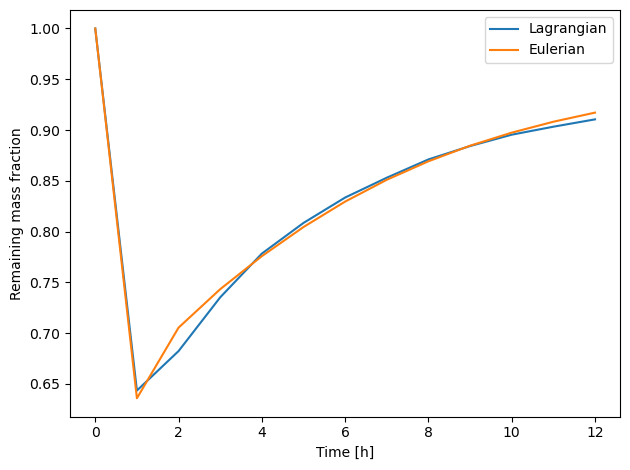

In [7]:
case = 3
profile = 'B'
# Update this to point to where you stored the simulation results
datafolder = '../results'

# Eulerian parameters to plot for
NJ = 1000  # Number of cells
NK = 8     # Number of classes
dt_E = 300 # Timestep
dt_save_E = 3600 # Interval for storing results

# Lagrangian parameters to plot for
Np = 100000 # Number of particles
dt_L = 30  # Timestep
dt_save_L = 3600 # Interval for storing results
run_id = 0 # Ensemble member

# Number of bins to use in particle histogram
Nbins = 100
# Max depth (constant for all cases)
Zmax = 50

# Load Lagrangian results
Z = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt_L}_save_dt={dt_save_L}_Z_{run_id:04}.npy'))
# Histogram bins and midpoints
bins, delta = np.linspace(0, Zmax, Nbins+1, retstep = True)
mids = bins[:-1] + delta/2

# Load Eulerian results
C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={dt_E}_save_dt={dt_save_E}.npy'))
# Cell faces and cell centers
zf, dz = np.linspace(0, Zmax, C.shape[-1]+1, retstep=True)
zc = zf[:-1] + dz/2


# Times
t_L = np.arange(Z.shape[0]) * dt_save_L
t_E = np.arange(C.shape[0]) * dt_save_E


plt.plot(t_L / 3600, np.sum(Z >= 0, axis=1) / Np, label='Lagrangian')
plt.plot(t_E / 3600, np.sum(C, axis=(1,2))*dz, label='Eulerian')
    
plt.legend()
plt.ylabel('Remaining mass fraction')
plt.xlabel('Time [h]')
plt.tight_layout()